# IMPORTS 

In [ ]:
#construction du modèle baseline 
import tensorflow as tf 
from tensorflow import keras
from keras import layers,regularizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import optimizers

#gestion du database
import pandas as pd

#gestion des vecteurs et matrices 
import numpy as np 

#affichages
import matplotlib.pyplot as plt
import seaborn as sns

#resampling et mesure de la qualité des prédictions 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.utils import resample
from sklearn.metrics import classification_report
import sklearn.utils as sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


#imports generaux 
import random
import os 
import time

#imports pour charger les fichiers
from urllib import request 
import shutil
import tarfile 

## Récuperation des données 



In [ ]:
! git clone https://github.com/Viperine2022/projet_long_GCN_internet.git

Cloning into 'projet_long_GCN_internet'...
remote: Enumerating objects: 558, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (284/284), done.
remote: Total 558 (delta 340), reused 480 (delta 265), pack-reused 0
Receiving objects: 100% (558/558), 88.31 MiB | 19.08 MiB/s, done.
Resolving deltas: 100% (340/340), done.
Checking out files: 100% (142/142), done.


In [ ]:
%cd projet_long_GCN_internet

/content/projet_long_GCN_internet


#Data load

##load dataset entier

In [ ]:
#dataset avec les données sur les AS
dataset_path = '/content/projet_long_GCN_internet/IMPLANTATION/PeeringDB/data_GCN/dataset_AS_pDB_.csv'
dataset_AS = pd.read_csv(dataset_path)

#ce dataset n'a pas été integré aux données utilisés pour la prédiction d'AS en baseline 
dataset_path = '/content/projet_long_GCN_internet/IMPLANTATION/PeeringDB/data_GCN/dataset_IXP_pDB_.csv'
dataset_IXP = pd.read_csv(dataset_path)


##Reduction des classes du dataset  

* Nombre classes ici peut prendre une valeur entre 1 et 10 (nombre maximal de classes)

* On prend toujours les X premières classes car elles sont ordonnées selon le nombre d'échantillons et il nous interesse de prendre les classes le plus representés dans le DataSet pour avoir un maximum de données d'entraînement 

In [ ]:
nombre_classes = 5
dataset_AS = dataset_AS[dataset_AS['info_type']<nombre_classes]

# DATA PROCESSING 

##Visualisation atributs

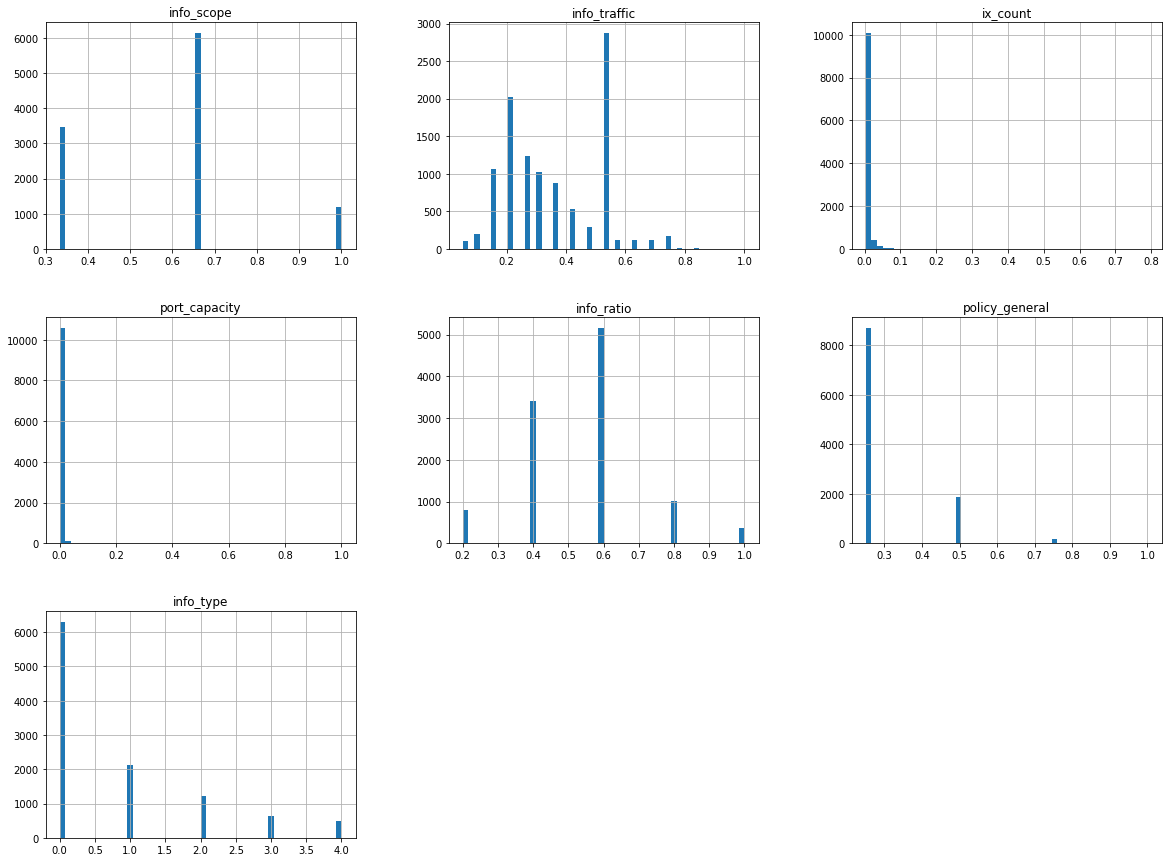

       info_scope  info_traffic  ix_count  port_capacity  info_ratio  \
0        1.000000      1.000000  0.515244       0.893224         1.0   
2        1.000000      0.736842  0.253049       0.272934         0.8   
3        0.666667      0.736842  0.152439       0.015179         0.4   
4        0.666667      0.736842  0.018293       0.013775         0.4   
5        1.000000      0.526316  0.003049       0.000745         0.6   
...           ...           ...       ...            ...         ...   
11402    0.333333      0.473684  0.006098       0.015637         1.0   
11403    0.333333      0.210526  0.006098       0.000745         0.4   
11404    0.666667      0.263158  0.003049       0.000037         1.0   
11405    0.666667      0.368421  0.003049       0.000372         0.6   
11406    0.666667      0.526316  0.006098       0.000465         0.6   

       policy_general  info_type  
0                0.25          2  
2                0.50          2  
3                0.50         

In [ ]:
dataset_AS.head()
dataset_AS.hist(bins=50, figsize=(20,15))
plt.show()
#affichage de l'allure generale 
print(dataset_AS)

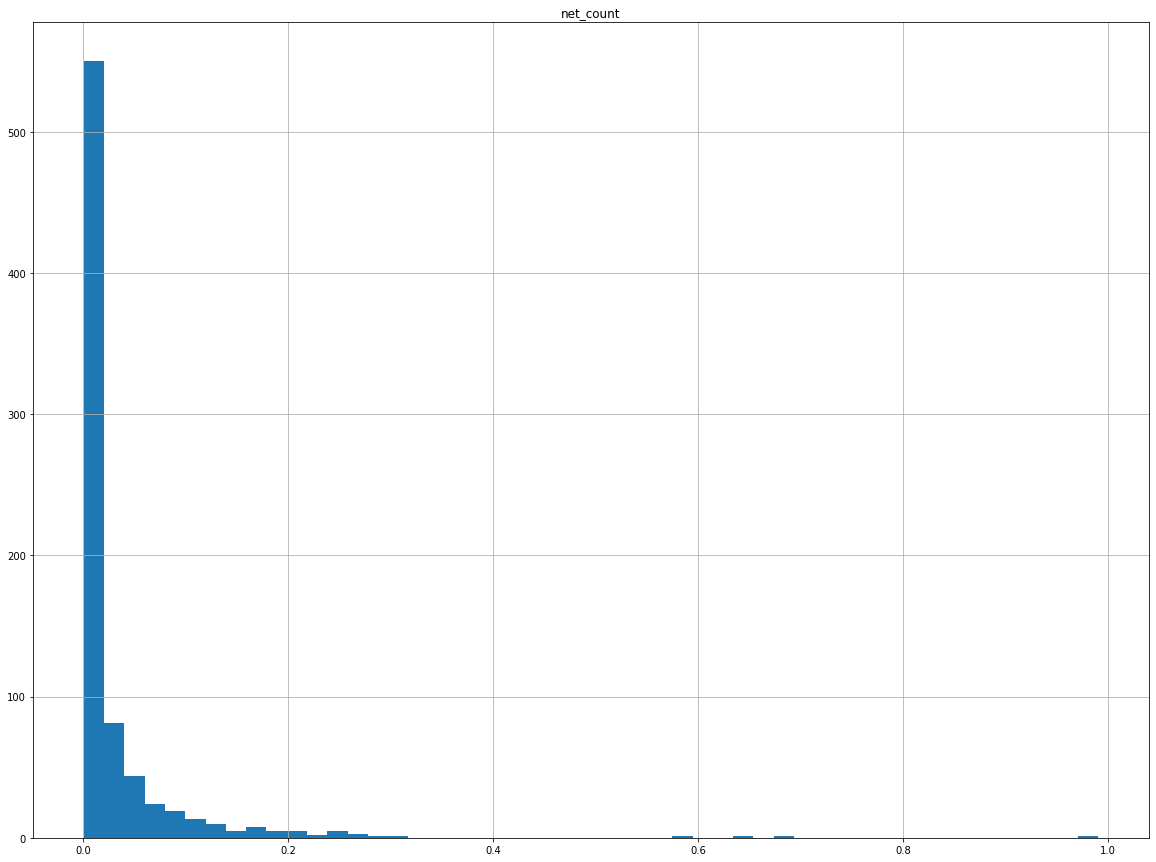

In [ ]:
#affichage des données IXP même si elles ne sont pas utilisés après 
dataset_IXP.head()
dataset_IXP.hist(bins=50, figsize=(20,15))
plt.show()

##Première Partition des données 
Découpage en un ensemble d'entraînement general et un ensemble de test 

In [ ]:
#géneration d'un seed random aléatoire pour le découpage  
etat_rand = random.randint(0, 101)
train_set, test_set = train_test_split(dataset_AS, test_size=0.2, random_state=etat_rand)

##Visualisation representation classes

0    6294
1    2135
2    1226
3     625
4     500
Name: info_type, dtype: int64


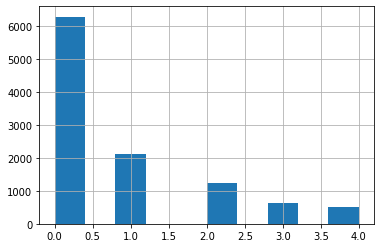

In [ ]:
print(dataset_AS["info_type"].value_counts())
per_class = dataset_AS["info_type"].value_counts()
dataset_AS["info_type"].hist()

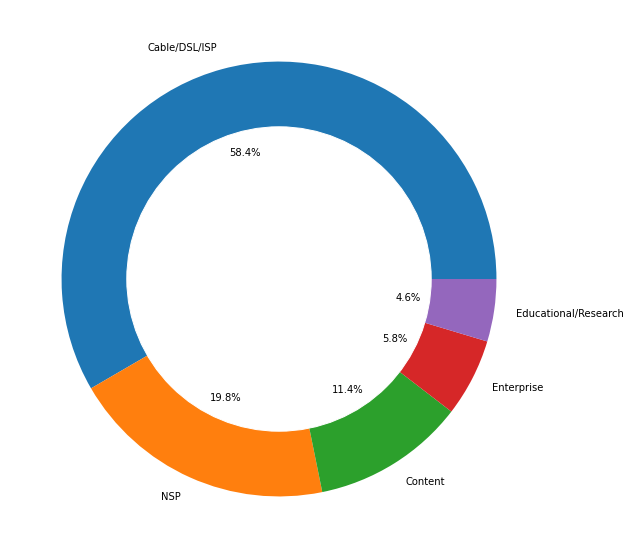

In [ ]:
classes = ["Cable/DSL/ISP", "NSP", "Content", "Enterprise", "Educational/Research","Non-Profit", "Route Server", "Network Services","Route Collector", "Government"]
classes = classes[:nombre_classes]
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=classes,autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

##Oversampling
pour avoir la même quantité de données dans toutes les classes. Le oversampling ici n'est pas vraiment viable car la quantité de données dans les plus petites classes est vraiment petite et la taille du dataset en general ne fait que 11.000 valeurs 

In [ ]:
#generation des seeds aléatoires
randStates = np.random.randint(0,101,nombre_classes)
NombreSamples = 5000

dfs = []
for i in range(nombre_classes):
  current_Df = train_set[train_set['info_type']==i]
  if current_Df.shape[0]>= NombreSamples:
    current_Df = current_Df.sample(n=NombreSamples,replace=True,random_state=randStates[i])
  else: 
    current_Df =  resample(resample(current_Df,replace=True,n_samples=NombreSamples,random_state=randStates[i]))
  dfs.append(current_Df)
train_set = pd.concat(dfs)

print(train_set['info_type'].value_counts())


0    5000
1    5000
2    5000
3    5000
4    5000
Name: info_type, dtype: int64


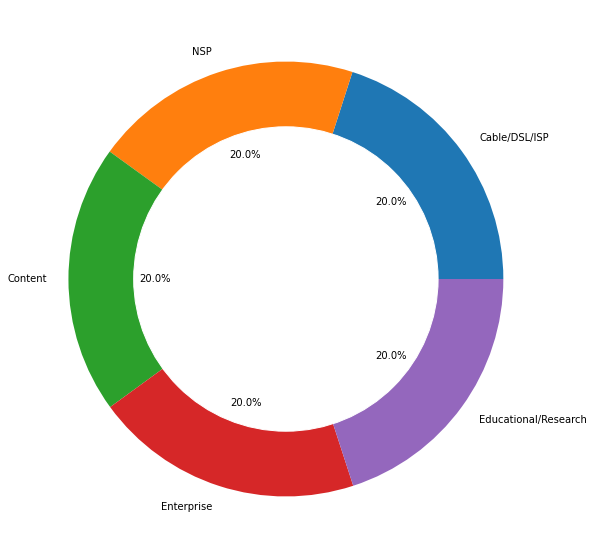

In [ ]:
# Représentation des classes
per_class_post = train_set["info_type"].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class_post, labels=classes,autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
print(train_set.keys())

Index(['info_scope', 'info_traffic', 'ix_count', 'port_capacity', 'info_ratio',
       'policy_general', 'info_type'],
      dtype='object')


In [ ]:
#choix d'attributs pour l'entraînement 
atributs = ['info_scope', 'info_traffic', 'ix_count', 'port_capacity','info_ratio', 'policy_general']

train_set_final, validation_set = train_test_split(train_set, test_size=0.2, random_state=etat_rand)

x_train = train_set_final[atributs]
y_train = train_set_final["info_type"]

x_val = validation_set[atributs]
y_val = validation_set["info_type"]

x_test = test_set[atributs]
y_test = test_set["info_type"]

#affichage des premières valeurs pour tous les ensembles generés 
print("dataframe des attributs ",x_train.head())
print("dataframe des labels ",y_train.head())
print("on utilise dans ce cas ",len(atributs)," attributs")

dataframe des attributs        info_scope  info_traffic  ix_count  port_capacity  info_ratio  \
1303    1.000000      0.421053  0.012195       0.001489         0.8   
2574    0.666667      0.157895  0.003049       0.000372         1.0   
8456    0.666667      0.526316  0.003049       0.000004         0.6   
7044    0.666667      0.210526  0.003049       0.000074         0.6   
3886    0.333333      0.421053  0.003049       0.000372         0.6   

      policy_general  
1303            0.25  
2574            0.25  
8456            0.25  
7044            0.50  
3886            0.25  
dataframe des labels  1303    2
2574    2
8456    0
7044    4
3886    4
Name: info_type, dtype: int64
on utilise dans ce cas  6  attributs


# MODEL TRAINING 

## Multi Layer Perceptron 
Pour orientation sur la construction regarder la baseline appliqué à CAIDA 

In [ ]:
#definition du modèle 
model = keras.Sequential(
    [Dense(input_dim=len(atributs),units =50,activation='tanh'),
     Dropout(0.2),
     Dense(50,activation='tanh'),
     Dropout(0.2),
     Dense(15,activation='tanh'),
     Dense(nombre_classes,activation='softmax')
])

In [ ]:
#compilation du modèle
opt = tf.keras.optimizers.Adam()
opt.learning_rate = 5e-3
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

Epoch 1/100
101/101 [==============================] - 1s 5ms/step - loss: 1.5553 - accuracy: 0.3086 - val_loss: 1.4323 - val_accuracy: 0.3902
Epoch 2/100
101/101 [==============================] - 0s 3ms/step - loss: 1.4387 - accuracy: 0.3742 - val_loss: 1.4188 - val_accuracy: 0.3964
Epoch 3/100
101/101 [==============================] - 0s 3ms/step - loss: 1.4286 - accuracy: 0.3833 - val_loss: 1.4126 - val_accuracy: 0.3858
Epoch 4/100
101/101 [==============================] - 0s 3ms/step - loss: 1.4124 - accuracy: 0.3983 - val_loss: 1.3875 - val_accuracy: 0.3984
Epoch 5/100
101/101 [==============================] - 0s 4ms/step - loss: 1.3960 - accuracy: 0.4020 - val_loss: 1.3681 - val_accuracy: 0.4169
Epoch 6/100
101/101 [==============================] - 0s 3ms/step - loss: 1.3859 - accuracy: 0.4103 - val_loss: 1.3722 - val_accuracy: 0.4205
Epoch 7/100
101/101 [==============================] - 0s 3ms/step - loss: 1.3730 - accuracy: 0.4126 - val_loss: 1.3566 - val_accuracy: 0.4249

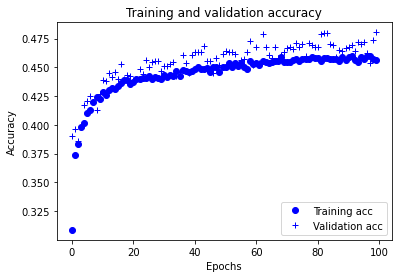

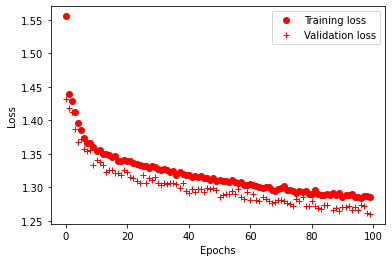

In [ ]:
#entraînement du modèle
epochs_ = 100
output = model.fit(x=x_train, y=y_train, batch_size=200, epochs=epochs_,validation_data = [x_val,y_val])
history_dict = output.history
print(history_dict)

#affichage des figures : 
plt.plot(range(epochs_), history_dict["accuracy"], "bo", label="Training acc")
plt.plot(range(epochs_), history_dict["val_accuracy"], "b+", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#netoiages de la figure avant d'afficher la suivante 
plt.clf() 
plt.plot(range(epochs_), history_dict["loss"], "ro", label="Training loss")
plt.plot(range(epochs_), history_dict["val_loss"], "r+", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#validation du modèle sur les données de Test 
eval = model.evaluate(x_test,y_test)
print(eval)

68/68 [==============================] - 0s 1ms/step - loss: 1.3795 - accuracy: 0.4759
[1.3794611692428589, 0.4758812487125397]


In [ ]:
#verification de la puissance d'inference (test du modèle pour prédire des nvx données) 
predictions = model.predict(x_test)

#on verifie la forme des predictions et on valide par rapport au nombre de classes choisis
print(predictions.shape)

#On retrouve la classe selectionné par la distribution de probabilité calculé par le reseaux neuronaux 
predictedClass = np.argmax(predictions,axis=1)
uniq,freq = np.unique(predictedClass,return_counts=True)

#Affichage des prédictions 
print(predictedClass)
print("Valeurs uniques predicted: ",uniq)
print("Frequence valeurs predicted: ",freq)

#Affichage des labels pour l'ensemble de tests 
y_test_np = y_test.to_numpy()
trueClass = y_test_np
uniq,freq = np.unique(trueClass,return_counts=True)
print("Valeurs uniques dans les test: ",uniq)
print("Frequence valeurs dans les test: ",freq)

(2156, 10)
[4 0 1 ... 2 4 0]
Valeurs uniques predicted:  [0 1 2 3 4]
Frequence valeurs predicted:  [926 352 259 321 298]
Valeurs uniques dans les test:  [0 1 2 3 4]
Frequence valeurs dans les test:  [1279  418  228  130  101]


[0 0 0 ... 1 2 0]
Matrice de confusion
Accuracy sur base de test : 0.47588126159554733


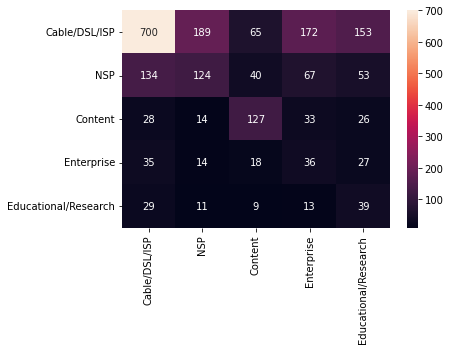

In [ ]:
#affichage de la matrice de confusion 
print(trueClass)
N_CLASSES = nombre_classes
print('Matrice de confusion')
conf=confusion_matrix(trueClass,predictedClass)
sns.heatmap(data=conf,fmt='.0f',xticklabels=classes,yticklabels=classes,annot=True)


# score de performance
print('Accuracy sur base de test :',accuracy_score(trueClass,predictedClass))

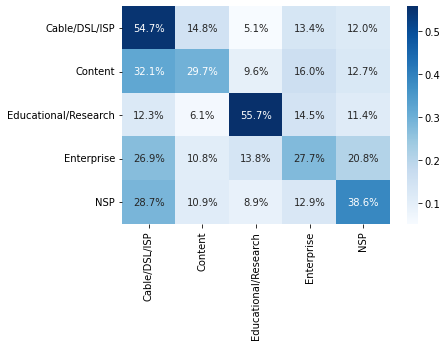

In [ ]:
sns.heatmap(conf/(np.sum(conf,axis=1)[:,None]), annot=True, 
            fmt='.1%', cmap='Blues',xticklabels=np.unique(classes[:N_CLASSES]),yticklabels=np.unique(classes[:N_CLASSES]))

In [ ]:
#affichage du classification report sur les données 
cr = classification_report(trueClass,predictedClass,target_names=classes)
print(cr)

                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.76      0.55      0.63      1279
                 NSP       0.35      0.30      0.32       418
             Content       0.49      0.56      0.52       228
          Enterprise       0.11      0.28      0.16       130
Educational/Research       0.13      0.39      0.20       101

            accuracy                           0.48      2156
           macro avg       0.37      0.41      0.37      2156
        weighted avg       0.58      0.48      0.51      2156



##RANDOM FOREST BASELINE 

[3 1 1 ... 2 3 0]
Matrice de confusion foret aléatoire
Accuracy sur base de test : 0.4114100185528757
2156


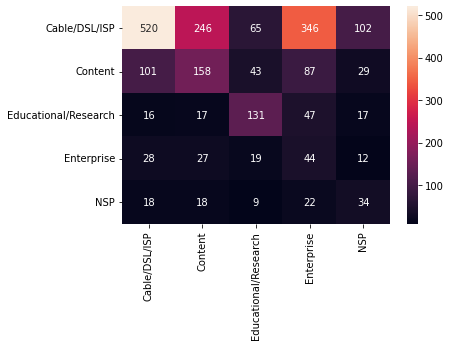

In [ ]:
clf = RandomForestClassifier(max_depth=4, random_state=0)

clf.fit(x_train, y_train)

LabelTest_prediction_forest = clf.predict(x_test)
LabelTest_prediction_forest = LabelTest_prediction_forest

print(LabelTest_prediction_forest)
print('Matrice de confusion foret aléatoire')
cm=confusion_matrix(trueClass,LabelTest_prediction_forest)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(classes[:N_CLASSES]),yticklabels=np.unique(classes[:N_CLASSES]),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(trueClass,LabelTest_prediction_forest))
print(y_test.count())

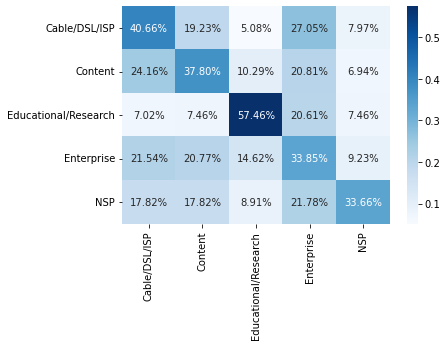

In [ ]:
sns.heatmap(cm/(np.sum(cm,axis=1)[:,None]), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=np.unique(classes[:N_CLASSES]),yticklabels=np.unique(classes[:N_CLASSES]))

In [ ]:
cr = classification_report(trueClass,LabelTest_prediction_forest,target_names=classes)
print(cr)

                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.76      0.41      0.53      1279
                 NSP       0.34      0.38      0.36       418
             Content       0.49      0.57      0.53       228
          Enterprise       0.08      0.34      0.13       130
Educational/Research       0.18      0.34      0.23       101

            accuracy                           0.41      2156
           macro avg       0.37      0.41      0.36      2156
        weighted avg       0.58      0.41      0.46      2156

